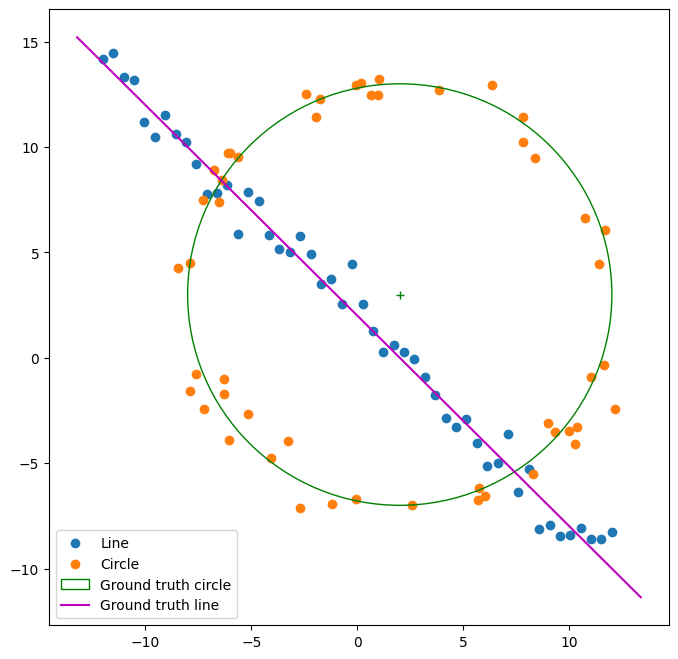

In [211]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
#import tikzplotlib

# np.random.seed(0)
N = 100
half_n = N // 2
r_init = 10
x0_gt, y0_gt = 2, 3 # Center
s = r_init / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r_init + n) * np.cos(t), y0_gt + (r_init + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))
s = 1.
m_init, b_init = -1, 2
x = np.linspace(-12, 12, half_n)
y = m_init * x + b_init + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line)) # All points

fig, ax = plt.subplots(1 ,1 , figsize =(8 ,8))
ax.scatter(X_line[:, 0], X_line[:, 1], label = 'Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label = 'Circle')
ax = plt.gca()
circle_gt = plt.Circle((x0_gt, y0_gt), r_init, color = 'g', fill = False, label = 'Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color = 'g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m_init * x_ + b_init
plt.plot(x_, y_, color = 'm', label = 'Ground truth line')
plt.legend()

In [212]:
# Define a function to calculate the distance between a point and a line
def point_line_distance(point, line_params):
    a, b, d = line_params
    x, y = point
    return abs(a*x + b*y + d) / np.sqrt(a*a + b*b)

# RANSAC parameters for estimating the line
max_iterations_line = 1000
min_inliers_line = 50
inlier_threshold_line = 1.4

best_line_params = None
best_line_inliers = []

for _ in range(max_iterations_line):
    # Randomly sample two points to define a line
    sample_indices_line = np.random.choice(N, 2, replace=False)
    sample_points_line = X[sample_indices_line]

    # Calculate line parameters (a, b, d) using the two points
    x1, y1 = sample_points_line[0]
    x2, y2 = sample_points_line[1]
    a = y2 - y1
    b = x1 - x2
    d = x2*y1 - x1*y2
    norm = np.sqrt(a*a + b*b)
    a /= norm
    b /= norm
    d /= norm

    # Count inliers based on the distance threshold
    inliers = [i for i, point in enumerate(X) if point_line_distance(point, (a, b, d)) < inlier_threshold_line]
    print(inliers)

    if len(inliers) >= min_inliers_line:
      best_line_inliers = inliers
      break

# Number of consensus points
print('No. of consensus points for line:', len(best_line_inliers))

[5, 7, 27, 30, 33, 34, 37, 47, 99]
[3, 6, 11, 13, 17, 18, 19, 25, 32, 36, 44, 90, 92, 93, 94, 95, 96, 97, 98, 99]
[25, 26, 32, 40, 44, 45, 68, 70, 71, 72, 74]
[20, 23, 39, 41, 49, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]
[7, 27, 36, 47, 73, 74, 75, 76, 77, 78, 79, 80]
[14, 15, 20, 28, 39, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 88, 89, 91, 96, 97, 98, 99]
[5, 30, 33, 34, 35, 37, 63, 67, 68, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 89]
[0, 6, 18, 44, 70, 71, 72, 73, 74]
[11, 13, 17, 87, 90, 92, 93, 94, 95, 96, 97, 98]
[1, 31, 35, 38, 46, 73, 75, 76, 77, 78, 79, 80]
[5, 14, 15, 23, 28, 30, 33, 34, 37, 39, 41, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80]
[14, 15, 20, 23, 28, 39, 41, 49, 50, 51

[-0.96867964] [2.31064978]


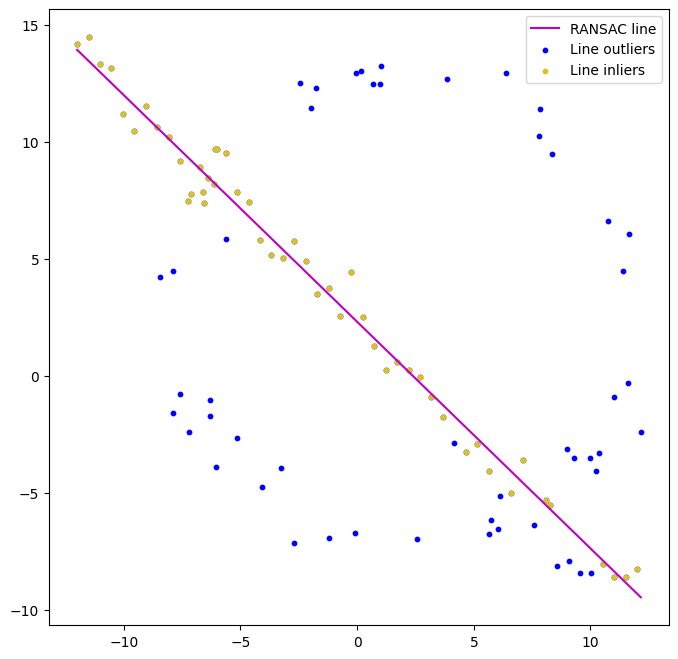

In [213]:
# Estimate the line parameters using the consensus set
xl = X[best_line_inliers,0]
yl = X[best_line_inliers,1]
A = np.hstack((xl.reshape(len(xl),1), np.ones((len(xl),1))))
b_ = yl.reshape(len(yl),1)
best_line_params = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b_)
m_line = best_line_params[0]
c_line = best_line_params[1]
print(m_line, c_line)

# Plotting the line
x = X[:,0]
y = X[:,1]
x_ = np.array([np.min(x), np.max(x)])
y_ = m_line * x_ + c_line
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plt.gca()
plt.plot(x_, y_, color='m', label='RANSAC line')
plt.scatter(x, y, label='Line outliers', color='b', s=10)
plt.scatter(xl, yl, label='Line inliers', color='#DDC21B', s=10)
plt.legend(loc='best')

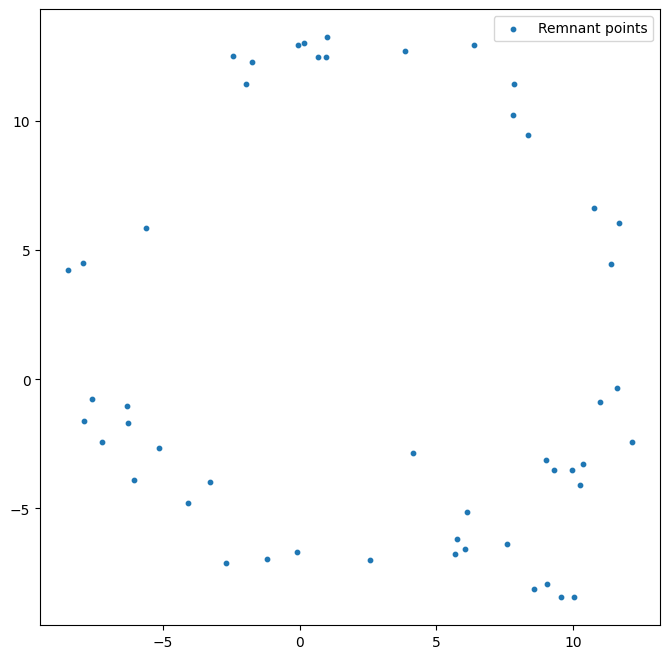

In [214]:
# Subtract the line inliers from all points to get the remnant points
remnant_points = np.delete(X, best_line_inliers, axis=0)

# plot the remnant points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plt.gca()
x_remnant = remnant_points[:,0]
y_remnant = remnant_points[:,1]
plt.scatter(x_remnant, y_remnant, label='Remnant points', s=10)
plt.legend(loc='best')

In [215]:
# Define a function to calculate the distance between a point and a circle
def point_circle_distance(point, circle_params):
    x_center, y_center, r = circle_params
    x, y = point
    return abs(np.sqrt((x - x_center)**2 + (y - y_center)**2) - r)

# RANSAC parameters for estimating the circle
max_iterations_circle = 1000
min_inliers_circle = 30
radial_error_threshold_circle = 1

best_circle_params = None
best_circle_inliers = []

for _ in range(max_iterations_circle):
    # Randomly sample three points to define a circle
    sample_indices_circle = np.random.choice(len(remnant_points), 3, replace=False)
    sample_points_circle = remnant_points[sample_indices_circle]

    # Calculate circle parameters (x_center, y_center, r) using the three points
    x1, y1 = sample_points_circle[0]
    x2, y2 = sample_points_circle[1]
    x3, y3 = sample_points_circle[2]
    D = 2 * (x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
    x_center = ((x1**2 + y1**2)*(y2-y3) + (x2**2 + y2**2)*(y3-y1) + (x3**2 + y3**2)*(y1-y2)) / D
    y_center = ((x1**2 + y1**2)*(x3-x2) + (x2**2 + y2**2)*(x1-x3) + (x3**2 + y3**2)*(x2-x1)) / D
    r = np.sqrt((x1-x_center)**2 + (y1-y_center)**2)

    # Count inliers based on the radial error threshold
    inliers = [i for i, point in enumerate(remnant_points) if point_circle_distance(point, (x_center, y_center, r)) < radial_error_threshold_circle]

    if len(inliers) >= min_inliers_circle:
        if len(inliers) > len(best_circle_inliers):
            best_circle_params = (x_center, y_center, r)
            best_circle_inliers = inliers

# Number of consensus points
print('No. of consensus points for circle:', len(best_circle_inliers))

# RANSAC circle parameters
print('Circle parameters:', best_circle_params)

No. of consensus points for circle: 40
Circle parameters: (1.7916512885188216, 2.669679734785259, 9.872318592003769)


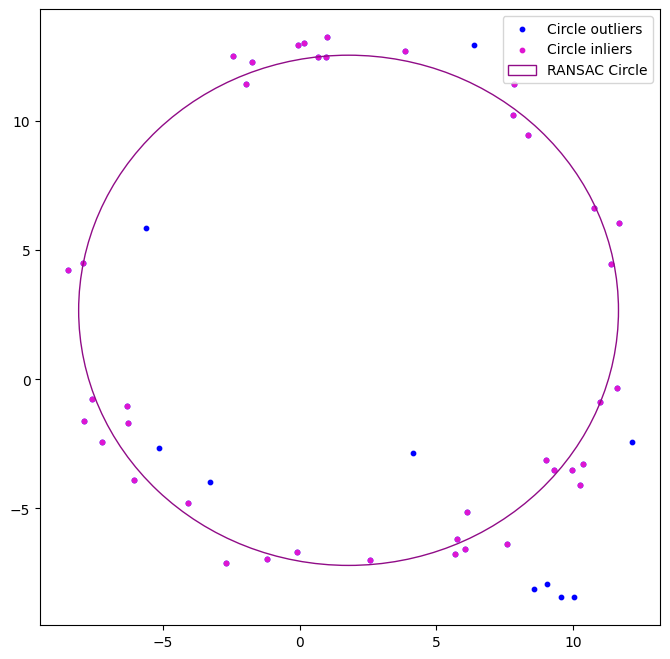

In [216]:
# Plot the circle
x = remnant_points[:, 0]
y = remnant_points[:, 1]
xc = remnant_points[best_circle_inliers, 0]
yc = remnant_points[best_circle_inliers, 1]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plt.gca()
plt.scatter(x, y, label='Circle outliers', color='b', s=10)
plt.scatter(xc, yc, label='Circle inliers', color='#DF15D1', s=10)
ransac_circle = plt.Circle((best_circle_params[0], best_circle_params[1]), best_circle_params[2], color='#900C87', fill=False, label='RANSAC Circle')
ax.add_patch(ransac_circle)
plt.legend(loc='best')
plt.show()

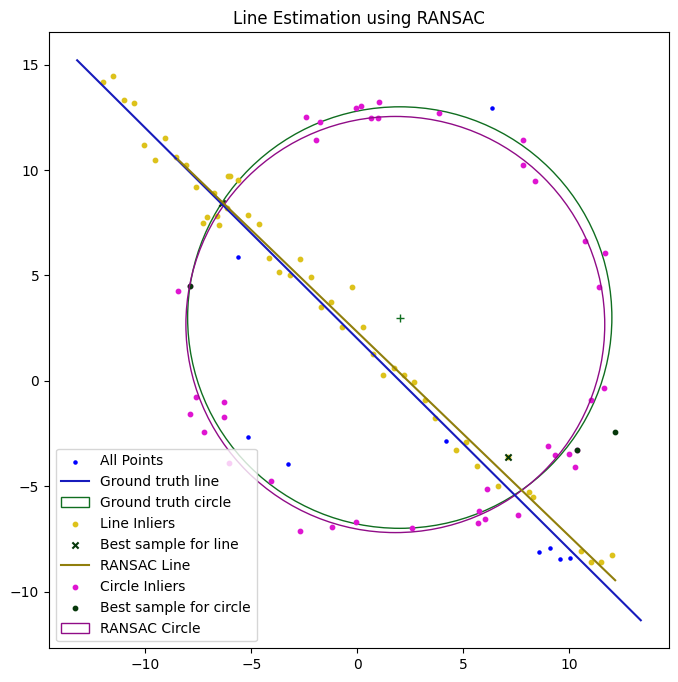

In [217]:
# Plot the line and inliers
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plt.gca()

# All points
ax.scatter(X[:, 0], X[:, 1], label='All Points', color='b', s=5)

# Ground truth line
x_ = np.array([x_min, x_max])
y_ = m_init * x_ + b_init
plt.plot(x_, y_, color = '#171BBC', label = 'Ground truth line')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r_init, color = '#106E20', fill = False, label = 'Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color = '#106E20')

# Line inliers
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], label='Line Inliers', color='#DDC21B', s=10)

# Best sample for line
ax.scatter(sample_points_line[:,0], sample_points_line[:,1], label='Best sample for line', color='#07380b', s=20, marker = 'x')

# RANSAC line
x_ = np.array([np.min(x), np.max(x)])
y_ = m_line * x_ + c_line
plt.plot(x_, y_, color='#907E0C', label='RANSAC Line')

# Circle inliers
ax.scatter(remnant_points[best_circle_inliers, 0], remnant_points[best_circle_inliers, 1], label='Circle Inliers', color='#DF15D1', s=10)

# Best sample for circle
ax.scatter(sample_points_circle[:,0], sample_points_circle[:,1], label='Best sample for circle', color='#07380b', s=10)

# RANSAC circle
circle = plt.Circle((best_circle_params[0], best_circle_params[1]), best_circle_params[2], color='#900C87', fill=False, label='RANSAC Circle')
ax.add_patch(circle)

plt.legend()
plt.title('Line Estimation using RANSAC')
plt.show()

40


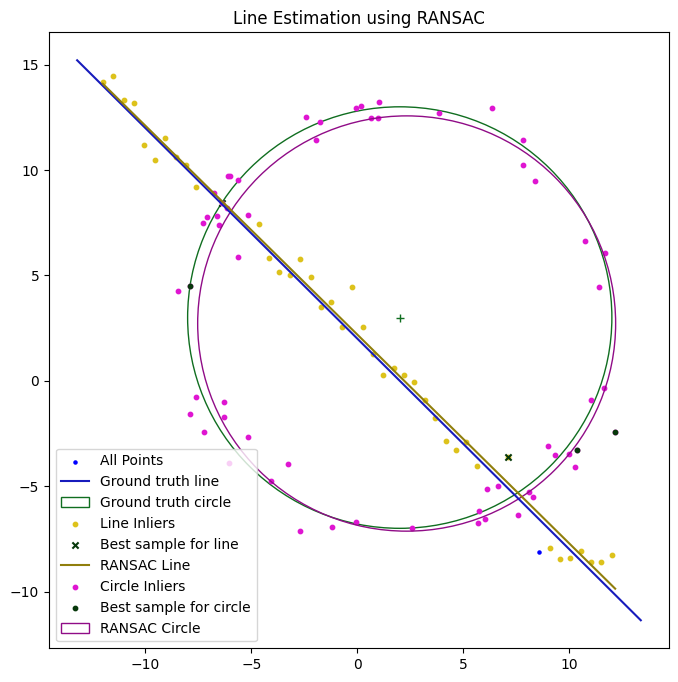

Circle parameters: (2.325735306182587, 2.717454445647515, 9.85189895414689)
Line parameters: [[-0.99183762]
 [ 2.19257051]]


In [227]:

# Define a function to calculate the distance between a point and a circle
def point_circle_distance(point, circle_params):
    x_center, y_center, r = circle_params
    x, y = point
    return abs(np.sqrt((x - x_center)**2 + (y - y_center)**2) - r)

# RANSAC parameters for estimating the circle
max_iterations_circle = 1000
min_inliers_circle = 45
radial_error_threshold_circle = 1.4

best_circle_params = None
best_circle_inliers = []

for _ in range(max_iterations_circle):
    # Randomly sample three points to define a circle
    sample_indices = np.random.choice(len(X), 3, replace=False)
    sample_points = X[sample_indices]

    # Calculate circle parameters (x_center, y_center, r) using the three points
    x1, y1 = sample_points[0]
    x2, y2 = sample_points[1]
    x3, y3 = sample_points[2]
    D = 2 * (x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
    x_center = ((x1**2 + y1**2)*(y2-y3) + (x2**2 + y2**2)*(y3-y1) + (x3**2 + y3**2)*(y1-y2)) / D
    y_center = ((x1**2 + y1**2)*(x3-x2) + (x2**2 + y2**2)*(x1-x3) + (x3**2 + y3**2)*(x2-x1)) / D
    r = np.sqrt((x1-x_center)**2 + (y1-y_center)**2)

    # Count inliers based on the radial error threshold
    inliers = [i for i, point in enumerate(X) if point_circle_distance(point, (x_center, y_center, r)) < radial_error_threshold_circle]

    if len(inliers) >= min_inliers_circle:
        if len(inliers) > len(best_circle_inliers):
            best_circle_params = (x_center, y_center, r)
            best_circle_inliers = inliers

# Subtract the line inliers from all points to get the remnant points
remnant_points = np.delete(X, best_circle_inliers, axis=0)

# Define a function to calculate the distance between a point and a line
def point_line_distance(point, line_params):
    a, b, d = line_params
    x, y = point
    return abs(a*x + b*y + d) / np.sqrt(a*a + b*b)

# RANSAC parameters for estimating the line
max_iterations_line = 1000
min_inliers_line = 40
inlier_threshold_line = 1.6

best_line_params = None
best_line_inliers = []

for _ in range(max_iterations_line):
    # Randomly sample two points to define a line
    sample_indices = np.random.choice(len(remnant_points), 2, replace=False)
    sample_points = remnant_points[sample_indices]

    # Calculate line parameters (a, b, d) using the two points
    x1, y1 = sample_points[0]
    x2, y2 = sample_points[1]
    a = y2 - y1
    b = x1 - x2
    d = x2*y1 - x1*y2
    norm = np.sqrt(a*a + b*b)
    a /= norm
    b /= norm
    d /= norm

    # Count inliers based on the distance threshold
    inliers = [i for i, point in enumerate(remnant_points) if point_line_distance(point, (a, b, d)) < inlier_threshold_line]

    if len(inliers) >= min_inliers_line:
      best_line_inliers = inliers
      break

print(len(best_line_inliers))
# Estimate the line parameters using the consensus set
xl = remnant_points[best_line_inliers,0]
yl = remnant_points[best_line_inliers,1]
A = np.hstack((xl.reshape(len(xl),1), np.ones((len(xl),1))))
b_ = yl.reshape(len(yl),1)
best_line_params = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b_)
m_line = best_line_params[0]
c_line = best_line_params[1]

# Plotting the line
x = X[:,0]
y = X[:,1]
x_ = np.array([np.min(x), np.max(x)])
y_ = m_line * x_ + c_line

# Plot the line and inliers
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plt.gca()

# All points
ax.scatter(X[:, 0], X[:, 1], label='All Points', color='b', s=5)

# Ground truth line
x_ = np.array([x_min, x_max])
y_ = m_init * x_ + b_init
plt.plot(x_, y_, color = '#171BBC', label = 'Ground truth line')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r_init, color = '#106E20', fill = False, label = 'Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color = '#106E20')

# Line inliers
ax.scatter(remnant_points[best_line_inliers, 0], remnant_points[best_line_inliers, 1], label='Line Inliers', color='#DDC21B', s=10)

# Best sample for line
ax.scatter(sample_points_line[:,0], sample_points_line[:,1], label='Best sample for line', color='#07380b', s=20, marker = 'x')

# RANSAC line
x_ = np.array([np.min(x), np.max(x)])
y_ = m_line * x_ + c_line
plt.plot(x_, y_, color='#907E0C', label='RANSAC Line')

# Circle inliers
ax.scatter(X[best_circle_inliers, 0], X[best_circle_inliers, 1], label='Circle Inliers', color='#DF15D1', s=10)

# Best sample for circle
ax.scatter(sample_points_circle[:,0], sample_points_circle[:,1], label='Best sample for circle', color='#07380b', s=10)

# RANSAC circle
circle = plt.Circle((best_circle_params[0], best_circle_params[1]), best_circle_params[2], color='#900C87', fill=False, label='RANSAC Circle')
ax.add_patch(circle)

plt.legend()
plt.title('Line Estimation using RANSAC')
plt.show()

print('Circle parameters:', best_circle_params)
print('Line parameters:', best_line_params)